# **ANT COLONY** *Caso Base*


In [1]:
import numpy as np
import pandas as pd

In [2]:
clients=pd.read_csv("clients.csv")
depots=pd.read_csv("depots.csv")
vehicles=pd.read_csv("vehicles.csv")#.drop("Capacity", axis=1)

In [3]:
def haversine(lat1, lon1, lat2, lon2):
  R = 6371
  phi1, phi2 = np.radians(lat1), np.radians(lat2)
  dphi = np.radians(lat2 - lat1)
  dlambda = np.radians(lon2 - lon1)
  a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
  return 2 * R * np.arcsin(np.sqrt(a))

In [4]:
distancias=np.zeros((len(depots)+len(clients)+1,len(depots)+len(clients)+1))
distancias+=np.inf
pheromonas=np.ones((len(depots)+len(clients)+1,len(depots)+len(clients)+1))

In [5]:
locations={}
#distanciass depots a clientes
for i in range(len(depots)):
  lon1,lat1=depots.iloc[i].Longitude,depots.iloc[i].Latitude
  locations[int(depots.iloc[i]["LocationID"])-1]=(float(lat1),float(lon1))
  locations[25]=(float(lat1),float(lon1))
  for j in range(len(clients)):
    lon2,lat2=clients.iloc[j].Longitude,clients.iloc[j].Latitude
    #print(depots.iloc[i].LocationID,clients.iloc[j].LocationID,haversine(lat1,lon1,lat2,lon2))
    distancias[i,j+len(depots)]=haversine(lat1,lon1,lat2,lon2)
    distancias[j+len(depots),i]=haversine(lat1,lon1,lat2,lon2)

for i in range(len(clients)):
  lon1,lat1=clients.iloc[i].Longitude,clients.iloc[i].Latitude
  locations[int(clients.iloc[i]["LocationID"])-1]=(float(lat1),float(lon1))
  for j in range(len(clients)):
    if i!=j:
      lon2,lat2=clients.iloc[j].Longitude,clients.iloc[j].Latitude
      distancias[i+len(depots),j+len(depots)]=haversine(lat1,lon1,lat2,lon2)

In [6]:
deseabilidad=1/distancias

In [7]:
for i in range(len(distancias)):
  distancias[i,i]=0

## **Implementación metaheurística**

In [8]:
hormigas_plantillas=[]
for i in range(len(vehicles)):
  hormigas_plantillas.append(vehicles.iloc[i].to_dict())
hormigas_plantillas

[{'VehicleID': 1, 'Capacity': 130, 'Range': 170},
 {'VehicleID': 2, 'Capacity': 140, 'Range': 200},
 {'VehicleID': 3, 'Capacity': 120, 'Range': 180},
 {'VehicleID': 4, 'Capacity': 100, 'Range': 90},
 {'VehicleID': 5, 'Capacity': 70, 'Range': 100},
 {'VehicleID': 6, 'Capacity': 55, 'Range': 170},
 {'VehicleID': 7, 'Capacity': 110, 'Range': 150},
 {'VehicleID': 8, 'Capacity': 114, 'Range': 140}]

In [9]:
import random

alpha = 1
beta = 2

def construir_solucion(deseabilidad, pheromonas):
#    n_viajeros = len(hormigas_plantillas)
    n_nodos = len(deseabilidad)
    nodos_restantes = set(range(1, n_nodos-1))  # Excluye solo el nodo 0

    n_hormigas = len(hormigas_plantillas)

    rutas = [[0] for _ in range(n_hormigas)]  # Cada vehículo parte en el nodo 0
    recorridos = [0 for _ in range(n_hormigas)]

    while nodos_restantes:
        opciones = []

        # Construir todas las opciones posibles (vehículo, ciudad)
        for i in range(n_hormigas):
            actual = rutas[i][-1]
            for ciudad in nodos_restantes:
                nueva_distancia = distancias[actual][ciudad]
                retorno = distancias[ciudad][0]
                total_si_asigno = recorridos[i] + nueva_distancia + retorno
                if total_si_asigno <= hormigas_plantillas[i]["Range"]:
                    tau = pheromonas[actual][ciudad] ** alpha
                    eta = deseabilidad[actual][ciudad] ** beta
                    score = tau * eta
                    opciones.append((score, i, ciudad, nueva_distancia))

        if not opciones:
            raise Exception("No es posible cubrir todos los nodos con los rangos disponibles.")

        # Elegir una opción (vehículo, ciudad) con probabilidad proporcional a score
        scores = [op[0] for op in opciones]
        total_score = sum(scores)
        #print(total_score)
        if total_score == 0:
            seleccion = 0#random.choice(opciones)
        else:
            probabilidades = [s / total_score for s in scores]
            seleccion = random.choices(opciones, weights=probabilidades)[0]

        _, vehiculo_idx, ciudad, delta = seleccion
        rutas[vehiculo_idx].append(ciudad)
        recorridos[vehiculo_idx] += delta
        nodos_restantes.remove(ciudad)

    # Cerrar todas las rutas — incluso las que están vacías
    for i in range(n_hormigas):
        if rutas[i][-1] != 0:
            recorridos[i] += distancias[rutas[i][-1]][0]
            rutas[i].append(0)
        else:
            # Ya está en 0, solo añadir 0 si no se movió
            rutas[i].append(0)

    return rutas


In [10]:
def calcular_costo(rutas, distancias):
    total = 0
    for ruta in rutas:
        for i in range(len(ruta)-1):
            #print(ruta[i],ruta[i+1],distancias[ruta[i]][ruta[i+1]])
            total += distancias[ruta[i]][ruta[i+1]]
    return total

def actualizar_feromonas(pheromonas, hormigas, rho, Q):
    pheromonas *= (1 - rho)
    for rutas, costo in hormigas:
        deposito = 0
        for ruta in rutas:
            for i in range(len(ruta) - 1):
                a, b = ruta[i], ruta[i+1]
                pheromonas[a][b] += Q / costo
                pheromonas[b][a] = pheromonas[a][b]  # simetría



In [11]:
import matplotlib.pyplot as plt
def graficar(ls):
  ls=np.array(ls)
  fig,ax=plt.subplots()
  ax.scatter(ls[:,0],ls[:,1],c=ls[:,2])
  ax.plot(ls[:,0],ls[:,1])
  plt.show()

In [12]:
import folium
from folium import PolyLine, Marker, CircleMarker, Icon
from IPython.display import display

# 1) Creamos un mapa único, centrado en todas las ubicaciones
center = [
    sum(lat for lat,lon in locations.values()) / len(locations),
    sum(lon for lat,lon in locations.values()) / len(locations)
]
def graficar_solucion(mejor_solucion):
  m_all = folium.Map(location=center, zoom_start=11)

  # Colores distintos para cada vehículo
  colors = ['blue','green','purple','orange','darkred','cadetblue','darkgreen']
  # Si tienes más de len(colors) vehículos, los colores se irán repitiendo.
  nodos = set([i for i in range(len(distancias))])
  for n in nodos:
    entrega=''
    lat, lon = locations[n]
    color = 'blue' if n==0 or n==25 else 'green'
    CircleMarker(
        (lat, lon), radius=5,
        color=color, fill=True, fill_opacity=0.7,
        popup=f'Nodo {n}\n {entrega}'
    ).add_to(m_all)
    # marcador de recarga
  for idx, v in enumerate(mejor_solucion):
        color = colors[idx % len(colors)]
        usados =[(v[i],v[i+1]) for i in range(len(v)-1)]
        distancias_total=sum([distancias[v[i],v[i+1]] for i in range(len(v)-1)])
        print(f"Vehículo {v} tramos activos: {usados} con distancia de {distancias_total}" )

        # 2) Dibujar cada tramo con el color asignado
        for (i,j) in usados:
            dis=distancias[i,j]
            PolyLine(
                [locations[i], locations[j]],
                color=color, weight=3, opacity=0.8,
                popup=f'V{v}: {i}→{j} \n d:{dis}/{distancias_total}'
            ).add_to(m_all)
  display(m_all)


In [13]:
import random
pheromonas=np.ones((len(depots)+len(clients)+1,len(depots)+len(clients)+1))
n_iteraciones=50
evaporacion=0.2
n_hormigas=5
mejor_solucion = None
mejor_costo = float('inf')
costos=[]
for it in range(n_iteraciones):
    hormigas = []
    for _ in range(n_hormigas):
        rutas = construir_solucion(deseabilidad, pheromonas)
        #print(rutas)
        costo = calcular_costo(rutas, distancias)
        hormigas.append((rutas, costo))
        if costo < mejor_costo:
            mejor_solucion = rutas
            mejor_costo = costo
            costos.append((it+1,costo,_))
    actualizar_feromonas(pheromonas, hormigas, evaporacion, 1)

    print(f"Iteración {it+1}, Mejor costo: {mejor_costo:.2f}")

# === RESULTADOS ===
print("\nMejor solución encontrada:")
for i, ruta in enumerate(mejor_solucion):
    print(f"  Vendedor {i+1}: {ruta}")
print(f"Costo total: {mejor_costo:.2f}")

Iteración 1, Mejor costo: 195.67
Iteración 2, Mejor costo: 195.67
Iteración 3, Mejor costo: 195.67
Iteración 4, Mejor costo: 182.00
Iteración 5, Mejor costo: 182.00
Iteración 6, Mejor costo: 182.00
Iteración 7, Mejor costo: 182.00
Iteración 8, Mejor costo: 182.00
Iteración 9, Mejor costo: 182.00
Iteración 10, Mejor costo: 182.00
Iteración 11, Mejor costo: 182.00
Iteración 12, Mejor costo: 182.00
Iteración 13, Mejor costo: 182.00
Iteración 14, Mejor costo: 182.00
Iteración 15, Mejor costo: 182.00
Iteración 16, Mejor costo: 182.00
Iteración 17, Mejor costo: 182.00
Iteración 18, Mejor costo: 182.00
Iteración 19, Mejor costo: 182.00
Iteración 20, Mejor costo: 182.00
Iteración 21, Mejor costo: 182.00
Iteración 22, Mejor costo: 182.00
Iteración 23, Mejor costo: 182.00
Iteración 24, Mejor costo: 182.00
Iteración 25, Mejor costo: 182.00
Iteración 26, Mejor costo: 182.00
Iteración 27, Mejor costo: 182.00
Iteración 28, Mejor costo: 182.00
Iteración 29, Mejor costo: 182.00
Iteración 30, Mejor cos

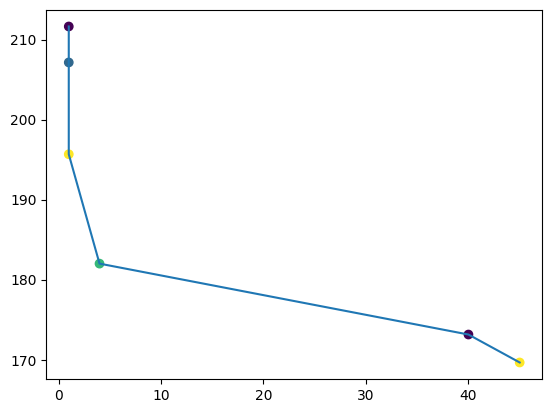

Vehículo [0, 11, 9, 17, 5, 8, 0] tramos activos: [(0, 11), (11, 9), (9, 17), (17, 5), (5, 8), (8, 0)] con distancia de 40.87099561506302
Vehículo [0, 3, 0] tramos activos: [(0, 3), (3, 0)] con distancia de 12.755624830168928
Vehículo [0, 6, 18, 13, 22, 4, 15, 1, 24, 16, 10, 0] tramos activos: [(0, 6), (6, 18), (18, 13), (13, 22), (22, 4), (4, 15), (15, 1), (1, 24), (24, 16), (16, 10), (10, 0)] con distancia de 50.81059094943242
Vehículo [0, 2, 19, 7, 21, 0] tramos activos: [(0, 2), (2, 19), (19, 7), (7, 21), (21, 0)] con distancia de 37.10285866163093
Vehículo [0, 0] tramos activos: [(0, 0)] con distancia de 0.0
Vehículo [0, 12, 0] tramos activos: [(0, 12), (12, 0)] con distancia de 11.88371712502287
Vehículo [0, 23, 14, 0] tramos activos: [(0, 23), (23, 14), (14, 0)] con distancia de 9.170683976160392
Vehículo [0, 20, 0] tramos activos: [(0, 20), (20, 0)] con distancia de 7.056246270146324


In [14]:
graficar(costos)
graficar_solucion(mejor_solucion)

In [15]:
import random
pheromonas=np.ones((len(depots)+len(clients)+1,len(depots)+len(clients)+1))
n_iteraciones=100
evaporacion=0.2
n_hormigas=10
mejor_solucion = None
mejor_costo = float('inf')
costos=[]
for it in range(n_iteraciones):
    hormigas = []
    for _ in range(n_hormigas):
        rutas = construir_solucion(deseabilidad, pheromonas)
        #print(rutas)
        costo = calcular_costo(rutas, distancias)
        hormigas.append((rutas, costo))
        if costo < mejor_costo:
            mejor_solucion = rutas
            mejor_costo = costo
            costos.append((it+1,costo,_))

    actualizar_feromonas(pheromonas, hormigas, evaporacion, 1)

    print(f"Iteración {it+1}, Mejor costo: {mejor_costo:.2f}")

# === RESULTADOS ===
print("\nMejor solución encontrada:")
for i, ruta in enumerate(mejor_solucion):
    print(f"  Vendedor {i+1}: {ruta}")
print(f"Costo total: {mejor_costo:.2f}")

Iteración 1, Mejor costo: 194.37
Iteración 2, Mejor costo: 194.37
Iteración 3, Mejor costo: 181.60
Iteración 4, Mejor costo: 181.60
Iteración 5, Mejor costo: 181.60
Iteración 6, Mejor costo: 181.60
Iteración 7, Mejor costo: 181.60
Iteración 8, Mejor costo: 180.39
Iteración 9, Mejor costo: 180.39
Iteración 10, Mejor costo: 174.71
Iteración 11, Mejor costo: 174.71
Iteración 12, Mejor costo: 174.71
Iteración 13, Mejor costo: 174.71
Iteración 14, Mejor costo: 174.71
Iteración 15, Mejor costo: 174.71
Iteración 16, Mejor costo: 174.71
Iteración 17, Mejor costo: 174.71
Iteración 18, Mejor costo: 174.71
Iteración 19, Mejor costo: 174.71
Iteración 20, Mejor costo: 174.71
Iteración 21, Mejor costo: 174.71
Iteración 22, Mejor costo: 174.71
Iteración 23, Mejor costo: 174.71
Iteración 24, Mejor costo: 174.71
Iteración 25, Mejor costo: 174.71
Iteración 26, Mejor costo: 174.71
Iteración 27, Mejor costo: 174.71
Iteración 28, Mejor costo: 174.71
Iteración 29, Mejor costo: 174.71
Iteración 30, Mejor cos

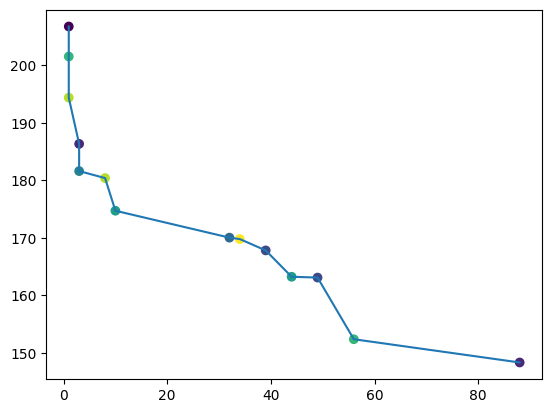

Vehículo [0, 8, 5, 9, 11, 17, 0] tramos activos: [(0, 8), (8, 5), (5, 9), (9, 11), (11, 17), (17, 0)] con distancia de 40.21895088118641
Vehículo [0, 6, 18, 13, 22, 4, 15, 1, 24, 16, 10, 0] tramos activos: [(0, 6), (6, 18), (18, 13), (13, 22), (22, 4), (4, 15), (15, 1), (1, 24), (24, 16), (16, 10), (10, 0)] con distancia de 50.81059094943242
Vehículo [0, 0] tramos activos: [(0, 0)] con distancia de 0.0
Vehículo [0, 12, 0] tramos activos: [(0, 12), (12, 0)] con distancia de 11.88371712502287
Vehículo [0, 23, 14, 3, 2, 19, 7, 21, 0] tramos activos: [(0, 23), (23, 14), (14, 3), (3, 2), (2, 19), (19, 7), (7, 21), (21, 0)] con distancia de 38.348593726136315
Vehículo [0, 0] tramos activos: [(0, 0)] con distancia de 0.0
Vehículo [0, 0] tramos activos: [(0, 0)] con distancia de 0.0
Vehículo [0, 20, 0] tramos activos: [(0, 20), (20, 0)] con distancia de 7.056246270146324


In [16]:
graficar(costos)
graficar_solucion(mejor_solucion)

In [17]:
import random
pheromonas=np.ones((len(depots)+len(clients)+1,len(depots)+len(clients)+1))
n_iteraciones=1000
evaporacion=0.2
n_hormigas=100
mejor_solucion = None
mejor_costo = float('inf')
costos=[]
for it in range(n_iteraciones):
    hormigas = []
    for _ in range(n_hormigas):
        rutas = construir_solucion(deseabilidad, pheromonas)
        #print(rutas)
        costo = calcular_costo(rutas, distancias)
        hormigas.append((rutas, costo))
        if costo < mejor_costo:
            mejor_solucion = rutas
            mejor_costo = costo
            costos.append((it+1,costo,_))

    actualizar_feromonas(pheromonas, hormigas, evaporacion, 1)
    if it%100==0:
      print(f"Iteración {it+1}, Mejor costo: {mejor_costo:.2f}")

# === RESULTADOS ===
print("\nMejor solución encontrada:")
for i, ruta in enumerate(mejor_solucion):
    print(f"  Vendedor {i+1}: {ruta}")
print(f"Costo total: {mejor_costo:.2f}")

Iteración 1, Mejor costo: 171.16
Iteración 101, Mejor costo: 144.44
Iteración 201, Mejor costo: 136.51
Iteración 301, Mejor costo: 136.51
Iteración 401, Mejor costo: 129.82
Iteración 501, Mejor costo: 129.82
Iteración 601, Mejor costo: 129.82
Iteración 701, Mejor costo: 129.82
Iteración 801, Mejor costo: 129.82
Iteración 901, Mejor costo: 129.82

Mejor solución encontrada:
  Vendedor 1: [0, 12, 0]
  Vendedor 2: [0, 3, 2, 19, 7, 21, 0]
  Vendedor 3: [0, 0]
  Vendedor 4: [0, 14, 23, 0]
  Vendedor 5: [0, 20, 0]
  Vendedor 6: [0, 0]
  Vendedor 7: [0, 5, 8, 18, 6, 13, 22, 15, 4, 1, 10, 16, 24, 17, 9, 11, 0]
  Vendedor 8: [0, 0]
Costo total: 129.82


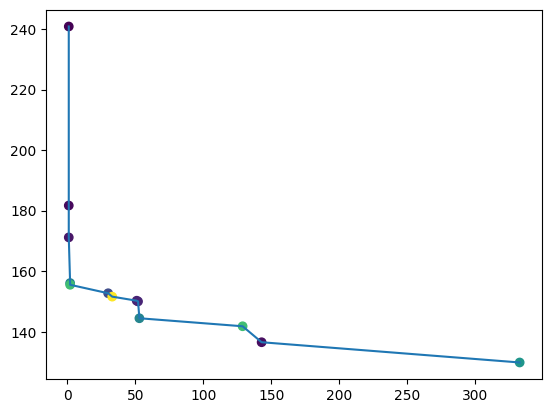

Vehículo [0, 12, 0] tramos activos: [(0, 12), (12, 0)] con distancia de 11.88371712502287
Vehículo [0, 3, 2, 19, 7, 21, 0] tramos activos: [(0, 3), (3, 2), (2, 19), (19, 7), (7, 21), (21, 0)] con distancia de 37.103829311732056
Vehículo [0, 0] tramos activos: [(0, 0)] con distancia de 0.0
Vehículo [0, 14, 23, 0] tramos activos: [(0, 14), (14, 23), (23, 0)] con distancia de 9.170683976160392
Vehículo [0, 20, 0] tramos activos: [(0, 20), (20, 0)] con distancia de 7.056246270146324
Vehículo [0, 0] tramos activos: [(0, 0)] con distancia de 0.0
Vehículo [0, 5, 8, 18, 6, 13, 22, 15, 4, 1, 10, 16, 24, 17, 9, 11, 0] tramos activos: [(0, 5), (5, 8), (8, 18), (18, 6), (6, 13), (13, 22), (22, 15), (15, 4), (4, 1), (1, 10), (10, 16), (16, 24), (24, 17), (17, 9), (9, 11), (11, 0)] con distancia de 64.60838352277369
Vehículo [0, 0] tramos activos: [(0, 0)] con distancia de 0.0


In [18]:
graficar(costos)
graficar_solucion(mejor_solucion)

## **Generacion csv verificación**

In [19]:
verificacion={
    "VehicleID":[],
    "Ruta":[],
    "Distancia (Km)":[],
    "# Destinos entregados":[],
    "Range(Km)":[]
}
for v,sol in enumerate(mejor_solucion):
  verificacion["VehicleID"].append(hormigas_plantillas[v]["VehicleID"])
  verificacion["Ruta"].append("-".join(map(str,sol)))
  verificacion["Distancia (Km)"].append(calcular_costo([sol],distancias))
  verificacion["# Destinos entregados"].append(len(sol)-2)
  verificacion["Range(Km)"].append(hormigas_plantillas[v]["Range"])
df=pd.DataFrame(verificacion)
df.to_csv("verificacion_metaheurística_antcolony_1.csv")
df

,VehicleID,Ruta,Distancia (Km),# Destinos entregados,Range(Km)
0,1,0-12-0,11.883717,1,170
1,2,0-3-2-19-7-21-0,37.103829,5,200
2,3,0-0,0.000000,0,180
3,4,0-14-23-0,9.170684,2,90
4,5,0-20-0,7.056246,1,100
5,6,0-0,0.000000,0,170
6,7,0-5-8-18-6-13-22-15-4-1-10-16-24-17-9-11-0,64.608384,15,150
7,8,0-0,0.000000,0,140
